In [8]:
import pandas as pd
import numpy as np

# Plotting tools
import pprint
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud as wc
from wordcloud import STOPWORDS
import scikitplot.metrics as skplt
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Text Cleaning and Preprocessing
from collections import Counter
from scipy.stats import expon
import unicodedata
import re
import string
from textblob import TextBlob
import spacy

import nltk
from nltk.corpus import stopwords

# sklearn
import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, classification_report, f1_score
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import train_test_split, cross_val_score, learning_curve, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import ShuffleSplit
from sklearn.manifold import TSNE
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB

import xgboost as xgb

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# Enable logging (for gensim)
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import time
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

#export model to a file
import joblib

## Loading data

In [10]:
flair_data = pd.read_csv('final_data.csv')

In [12]:
flair_data.head(1)

,body,comment,created,id,title,url,label,combined,combined_cleaned,combined_lemmatized
0,reposting lack activity r askindiahello last y...,dear policy holder dhavalcoholic request help ...,1.386254e+09,1s57oi,need feedback insurance policy took xpost aski...,https://www.reddit.com/r/india/comments/1s57oi...,AskIndia,https://www.reddit.com/r/india/comments/1s57oi...,reddit comments feedback insurance policy took...,reddit comment feedback insurance policy take ...


In [13]:
X_Train, X_Test, y_train, y_test = train_test_split(flair_data['combined_lemmatized'], flair_data['label'], random_state = 0, test_size = 0.3)

In [5]:
# loading the vectorizers from disk
cv_comments = joblib.load('bow_vec.pkl') # BOW
tfidf_comments = joblib.load('tfidf_vec.pkl') # TFIDF

In [14]:
X_train_comments, X_train_tfidf_comments = cv_comments.transform(X_Train), tfidf_comments.transform(X_Train)
X_train_text_df, X_train_tfidf_text_df = pd.DataFrame(X_train_comments.todense(), columns=[x+'_text' for x in cv_comments.get_feature_names()]), pd.DataFrame(X_train_tfidf_comments.todense(), columns=[x+'_text' for x in tfidf_comments.get_feature_names()])
X_train_text_df.shape, X_train_tfidf_text_df.shape

((1820, 212), (1820, 212))

In [15]:
X_test_comments, X_test_tfidf_comments = cv_comments.transform(X_Test), tfidf_comments.transform(X_Test)
X_test_text_df, X_test_tfidf_text_df = pd.DataFrame(X_test_comments.todense(), columns=[x+'_text' for x in cv_comments.get_feature_names()]), pd.DataFrame(X_test_tfidf_comments.todense(), columns=[x+'_text' for x in tfidf_comments.get_feature_names()])
X_test_text_df.shape, X_test_tfidf_text_df.shape

((780, 212), (780, 212))

## Models
#### Multinomial Naive Bayes' Classifier 

In [17]:
def run_the_mn_models(model, X_train, X_test, Y_tr, Y_te):
    X_train_text_df, X_test_text_df, y_train, y_test = X_train, X_test, Y_tr, Y_te
    
    if model == 'mnb1':
        
        mn_params = {
            'fit_prior': [True],
            'alpha': [0, 0.5, 1]}
        
        M = GridSearchCV(MultinomialNB(),
                        mn_params,
                        cv = 5,
                        verbose = 1,
                        n_jobs = -1)
        
    elif model == 'mnb2':
        
         mn_params = {
            'fit_prior': [False],
            'alpha': [0, 0.5, 1]}
        
         M = GridSearchCV(MultinomialNB(),
                        mn_params,
                        cv = 5,
                        verbose = 1,
                        n_jobs = -1)
        
    else:
        print('There is an error.')
        
    M.fit(X_train_text_df.values, y_train)
     
    print(f'Train score = {M.score(X_train_text_df.values, y_train)}')
    print(f'Test score = {M.score(X_test_text_df.values, y_test)}')
    
    predictions = M.predict(X_test_text_df.values)
    predictions_train = M.predict(X_train_text_df.values)
    print('--------')
    print(skplt.plot_confusion_matrix(y_test, predictions))
    print(f'Best params = {M.best_params_}')
    print('----F1 Score, Recall, Precision----')
    # print precision, recall, F1-score per each class/tag
    print(classification_report(y_test, predictions))
    
#     #skplt.plot_roc_curve(predictions,y_test)
#     print('----ROC AUC CURVE SCORE----')
#     print("ROC AUC CURVE SCORE FOR TEST: ",roc_auc_score(y_test, predictions))
#     print("ROC AUC CURVE SCORE FOR TRAIN: ",roc_auc_score(y_train, predictions_train))

#### Logistic Regression Classifier

In [18]:
def run_the_lr_models(model, X_train, X_test, Y_tr, Y_te):
    X_train_text_df, X_test_text_df, y_train, y_test = X_train, X_test, Y_tr, Y_te
    
    
    if model == 'lr1':
        
        lr_1_params = {
            'penalty': ['l1'],
            'C': [1, 1.5, 2, 2.5],
            'class_weight': ['balanced'],
            'warm_start': [True, False],
            'random_state': [42],
            'solver': ['liblinear']}
        
        M = GridSearchCV(LogisticRegression(),
                        lr_1_params,
                        cv = 5,
                        verbose = 1,
                        n_jobs = -1)
        
    elif model == 'lr2':
        
        lr_2_params = {
            'penalty': ['l2'],
            'C': [1, 1.5, 2, 2.5],
            'class_weight': ['balanced'],
            'warm_start': [True, False],            
            'random_state': [42],
            'solver': ['lbfgs', 'liblinear']}
        
        M = GridSearchCV(LogisticRegression(),
                        lr_2_params,
                        cv = 5,
                        verbose = 1,
                        n_jobs = -1)

    else:
        print('There is an error.')
        
    M.fit(X_train_text_df.values, y_train)
     
    print(f'Train score = {M.score(X_train_text_df.values, y_train)}')
    print(f'Test score = {M.score(X_test_text_df.values, y_test)}')
    
    predictions = M.predict(X_test_text_df.values)
    predictions_train = M.predict(X_train_text_df.values)
    print('--------')
    print(skplt.plot_confusion_matrix(y_test, predictions))
    print(f'Best params = {M.best_params_}')
    print('----F1 Score, Recall, Precision----')
    # print precision, recall, F1-score per each class/tag
    print(classification_report(y_test, predictions))
    
#     print('----ROC AUC CURVE SCORE----')
#     print("ROC AUC CURVE SCORE FOR TEST: ",roc_auc_score(y_test, predictions))
#     print("ROC AUC CURVE SCORE FOR TRAIN: ",roc_auc_score(y_train, predictions_train))
    
#     print('----ROC AUC CURVE SCORE----')
#     print("ROC AUC CURVE SCORE FOR TEST: ",roc_auc_score(y_test, predictions))
#     print("ROC AUC CURVE SCORE FOR TRAIN: ",roc_auc_score(y_train, predictions_train))

#### Random Forest Classifier

In [32]:
def run_the_rf_models(model, X_train, X_test, Y_tr, Y_te):
    X_train_text_df, X_test_text_df, y_train, y_test = X_train, X_test, Y_tr, Y_te
    
    if model == 'rf1':
        
        rf_params = {
            'n_estimators': [15, 24, 30],
            'criterion': ['gini'],
            'max_depth': [None, 5, 13, 21],
            'bootstrap': [True, False],
            'min_samples_split': [5, 7, 15, 25],
            'max_features': [None, 'log2', 'auto', .10, .25, .50],
            'warm_start': [True],
            'random_state': [42]}
        
        M = GridSearchCV(RandomForestClassifier(),
                        rf_params,
                        cv = 5,
                        verbose = 1,
                        n_jobs = -1)
        
    elif model == 'rf2':
        
        rf_none_params = {
            'n_estimators': [15, 24, 30],
            'criterion': ['entropy'],
            'max_depth': [None, 5, 13, 21],
            'bootstrap': [True, False],
            'min_samples_split': [5, 7, 15, 25],
            'max_features': [None, 'log2', 'auto',  .10, .25, .50],
            'warm_start': [True],
            'random_state': [42]}
        
        M = GridSearchCV(RandomForestClassifier(),
                        rf_none_params,
                        cv = 5,
                        verbose = 1,
                        n_jobs = -1)
        
    else:
        print('There is an error.')
        
    M.fit(X_train_text_df.values, y_train)
    
    #save in picle file
#     pickle.dump(M, open('model/model.pkl','wb'))
     
    print(f'Train score = {M.score(X_train_text_df.values, y_train)}')
    print(f'Test score = {M.score(X_test_text_df.values, y_test)}')
    
    predictions = M.predict(X_test_text_df.values)
    predictions_train = M.predict(X_train_text_df.values)
    
    print('--------')
    print(skplt.plot_confusion_matrix(y_test, predictions))
    print(f'Best params = {M.best_params_}')
    print('----F1 Score, Recall, Precision----')
    # print precision, recall, F1-score per each class/tag
    print(classification_report(y_test, predictions))
#     print('----ROC AUC CURVE SCORE----')
#     print("ROC AUC CURVE SCORE FOR TEST: ",roc_auc_score(y_test, predictions))
#     print("ROC AUC CURVE SCORE FOR TRAIN: ",roc_auc_score(y_train, predictions_train))

#### Support Vector Machine Classifier

In [49]:
def run_the_sv_models(model, X_train, X_test, Y_tr, Y_te):   
    X_train_text_df, X_test_text_df, y_train, y_test = X_train, X_test, Y_tr, Y_te
    
    if model == 'sv1':
        
        sv_params = {
            'kernel': ['rbf'], 
            'gamma': [1e-3, 1e-4],
            'C': [1, 10, 100, 1000] }
        
        M = GridSearchCV(SVC(probability=True),
                        sv_params,
                        cv = 5,
                        verbose = 1,
                        n_jobs = -1)
        
    elif model == 'sv2':
        
        
        sv_params = {
            'kernel': ['rbf'], 
            'gamma': [0.01, 1, 10, 100],
            'C': [1, 10, 100, 1000] }

        M = GridSearchCV(SVC(probability=True),
                        sv_params,
                        cv = 5,
                        verbose = 1,
                        n_jobs = -1)
        
    M.fit(X_train_text_df.values, y_train)
      
    #save in picle file
    joblib.dump(M, "SVM_TFIDF.pkl")
     
    print(f'Train score = {M.score(X_train_text_df.values, y_train)}')
    print(f'Test score = {M.score(X_test_text_df.values, y_test)}')
    
    predictions = M.predict(X_test_text_df.values)
    predictions_train = M.predict(X_train_text_df.values)
    
    print('--------')
    print(skplt.plot_confusion_matrix(y_test, predictions))
    print(f'Best params = {M.best_params_}')
    print('----F1 Score, Recall, Precision----')
    # print precision, recall, F1-score per each class/tag
    print(classification_report(y_test, predictions))
#     print('----ROC AUC CURVE SCORE----')
#     print("ROC AUC CURVE SCORE FOR TEST: ",roc_auc_score(y_test, predictions))
#     print("ROC AUC CURVE SCORE FOR TRAIN: ",roc_auc_score(y_train, predictions_train))

## Hyperparametric Tuning and Model Selection

##### BAG OF WORDS Vectorizer

Fitting 5 folds for each of 3 candidates, totalling 15 fits
Train score = 0.5862637362637363
Test score = 0.48846153846153845
--------


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    0.1s finished


AxesSubplot(0.125,0.125;0.62x0.755)
Best params = {'alpha': 1, 'fit_prior': True}
----F1 Score, Recall, Precision----
                    precision    recall  f1-score   support

               AMA       0.46      0.45      0.46        64
          AskIndia       0.39      0.47      0.43        57
  Business/Finance       0.53      0.41      0.46        68
       Coronavirus       0.55      0.43      0.48        65
              Food       0.78      0.72      0.75        58
     Non-Political       0.37      0.19      0.25        59
       Photography       0.27      0.55      0.36        51
    Policy/Economy       0.65      0.79      0.71        56
          Politics       0.60      0.44      0.51        66
         Scheduled       0.39      0.29      0.34        51
Science/Technology       0.68      0.78      0.73        64
            Sports       0.45      0.44      0.45        61
     [R]eddiquette       0.33      0.38      0.35        60

          accuracy                      

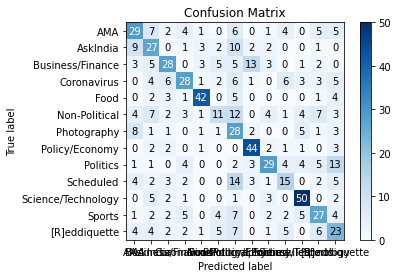

In [22]:
run_the_mn_models('mnb1', X_train_text_df, X_test_text_df, y_train, y_test)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
Train score = 0.5884615384615385
Test score = 0.4846153846153846
--------


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    0.1s finished
/opt/conda/lib/python3.7/site-packages/sklearn/naive_bayes.py:507: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


AxesSubplot(0.125,0.125;0.62x0.755)
Best params = {'alpha': 0, 'fit_prior': False}
----F1 Score, Recall, Precision----
                    precision    recall  f1-score   support

               AMA       0.40      0.47      0.43        64
          AskIndia       0.37      0.47      0.42        57
  Business/Finance       0.51      0.43      0.46        68
       Coronavirus       0.59      0.42      0.49        65
              Food       0.74      0.72      0.73        58
     Non-Political       0.32      0.19      0.24        59
       Photography       0.30      0.45      0.36        51
    Policy/Economy       0.65      0.79      0.71        56
          Politics       0.59      0.44      0.50        66
         Scheduled       0.39      0.29      0.34        51
Science/Technology       0.67      0.80      0.73        64
            Sports       0.45      0.44      0.45        61
     [R]eddiquette       0.33      0.38      0.35        60

          accuracy                     

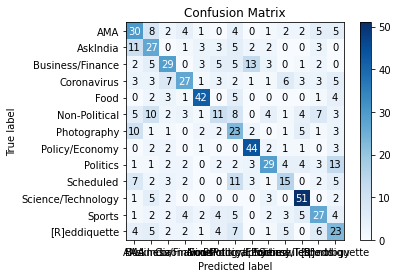

In [23]:
run_the_mn_models('mnb2', X_train_text_df, X_test_text_df, y_train, y_test)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    8.9s finished


Train score = 0.9175824175824175
Test score = 0.7064102564102565
--------
AxesSubplot(0.125,0.125;0.62x0.755)
Best params = {'C': 2, 'class_weight': 'balanced', 'penalty': 'l1', 'random_state': 42, 'solver': 'liblinear', 'warm_start': True}
----F1 Score, Recall, Precision----
                    precision    recall  f1-score   support

               AMA       0.67      0.61      0.64        64
          AskIndia       0.67      0.72      0.69        57
  Business/Finance       0.92      0.82      0.87        68
       Coronavirus       0.57      0.60      0.59        65
              Food       0.84      0.81      0.82        58
     Non-Political       0.57      0.61      0.59        59
       Photography       0.58      0.75      0.66        51
    Policy/Economy       0.87      0.84      0.85        56
          Politics       0.80      0.68      0.74        66
         Scheduled       0.52      0.47      0.49        51
Science/Technology       0.92      0.95      0.94        64
  

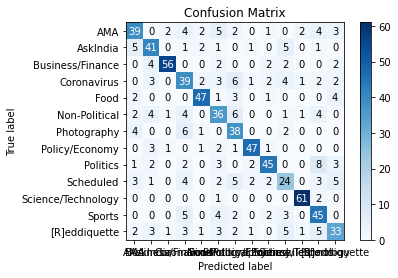

In [26]:
run_the_lr_models('lr1', X_train_text_df, X_test_text_df, y_train, y_test)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    5.8s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:   11.2s finished
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Train score = 0.9620879120879121
Test score = 0.7282051282051282
--------
AxesSubplot(0.125,0.125;0.62x0.755)
Best params = {'C': 2, 'class_weight': 'balanced', 'penalty': 'l2', 'random_state': 42, 'solver': 'lbfgs', 'warm_start': True}
----F1 Score, Recall, Precision----
                    precision    recall  f1-score   support

               AMA       0.70      0.69      0.69        64
          AskIndia       0.74      0.75      0.75        57
  Business/Finance       0.88      0.74      0.80        68
       Coronavirus       0.58      0.55      0.57        65
              Food       0.92      0.81      0.86        58
     Non-Political       0.67      0.66      0.67        59
       Photography       0.61      0.76      0.68        51
    Policy/Economy       0.85      0.89      0.87        56
          Politics       0.83      0.67      0.74        66
         Scheduled       0.55      0.65      0.59        51
Science/Technology       0.95      0.97      0.96        64
      

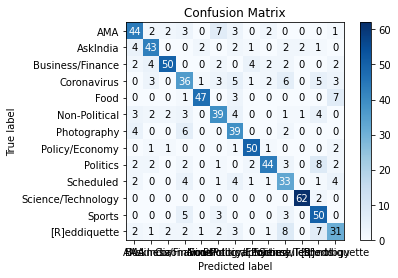

In [27]:
run_the_lr_models('lr2', X_train_text_df, X_test_text_df, y_train, y_test)

Fitting 5 folds for each of 576 candidates, totalling 2880 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   11.5s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   20.3s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   42.4s
[Parallel(n_jobs=-1)]: Done 1052 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 1634 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 2464 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 2880 out of 2880 | elapsed:  4.6min finished


Train score = 0.989010989010989
Test score = 0.7794871794871795
--------
AxesSubplot(0.125,0.125;0.62x0.755)
Best params = {'bootstrap': False, 'criterion': 'gini', 'max_depth': None, 'max_features': 0.1, 'min_samples_split': 5, 'n_estimators': 30, 'random_state': 42, 'warm_start': True}
----F1 Score, Recall, Precision----
                    precision    recall  f1-score   support

               AMA       0.77      0.75      0.76        64
          AskIndia       0.72      0.72      0.72        57
  Business/Finance       0.76      0.79      0.78        68
       Coronavirus       0.66      0.60      0.63        65
              Food       0.77      0.88      0.82        58
     Non-Political       0.84      0.80      0.82        59
       Photography       0.74      0.88      0.80        51
    Policy/Economy       0.82      0.91      0.86        56
          Politics       0.86      0.83      0.85        66
         Scheduled       0.79      0.82      0.81        51
Science/Techno

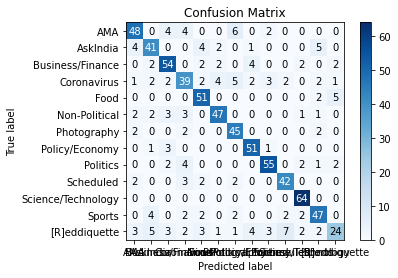

In [33]:
run_the_rf_models('rf1', X_train_text_df, X_test_text_df, y_train, y_test)

Fitting 5 folds for each of 576 candidates, totalling 2880 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   16.4s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   27.9s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 932 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 1382 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 1956 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 2702 tasks      | elapsed:  6.1min
[Parallel(n_jobs=-1)]: Done 2880 out of 2880 | elapsed:  6.6min finished


Train score = 0.9884615384615385
Test score = 0.7884615384615384
--------
AxesSubplot(0.125,0.125;0.62x0.755)
Best params = {'bootstrap': False, 'criterion': 'entropy', 'max_depth': None, 'max_features': 0.1, 'min_samples_split': 7, 'n_estimators': 30, 'random_state': 42, 'warm_start': True}
----F1 Score, Recall, Precision----
                    precision    recall  f1-score   support

               AMA       0.76      0.78      0.77        64
          AskIndia       0.60      0.72      0.66        57
  Business/Finance       0.75      0.88      0.81        68
       Coronavirus       0.70      0.60      0.64        65
              Food       0.82      0.88      0.85        58
     Non-Political       0.88      0.78      0.83        59
       Photography       0.74      0.88      0.80        51
    Policy/Economy       0.86      0.91      0.89        56
          Politics       0.88      0.85      0.86        66
         Scheduled       0.84      0.75      0.79        51
Science/Te

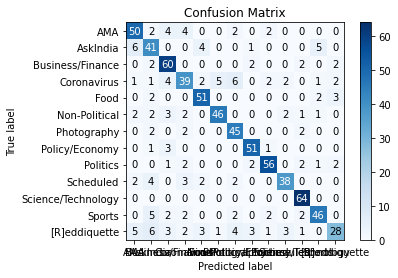

In [34]:
run_the_rf_models('rf2', X_train_text_df, X_test_text_df, y_train, y_test)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:   12.1s finished


Train score = 0.987912087912088
Test score = 0.7769230769230769
--------
AxesSubplot(0.125,0.125;0.62x0.755)
Best params = {'C': 1000, 'gamma': 0.001, 'kernel': 'rbf'}
----F1 Score, Recall, Precision----
                    precision    recall  f1-score   support

               AMA       0.82      0.70      0.76        64
          AskIndia       0.68      0.79      0.73        57
  Business/Finance       0.83      0.85      0.84        68
       Coronavirus       0.64      0.55      0.60        65
              Food       0.87      0.81      0.84        58
     Non-Political       0.81      0.75      0.78        59
       Photography       0.74      0.88      0.80        51
    Policy/Economy       0.84      0.95      0.89        56
          Politics       0.81      0.76      0.78        66
         Scheduled       0.68      0.75      0.71        51
Science/Technology       0.97      0.97      0.97        64
            Sports       0.78      0.80      0.79        61
     [R]eddique

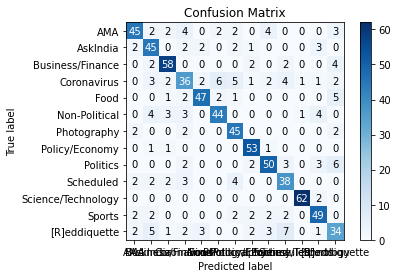

In [37]:
run_the_sv_models('sv1', X_train_text_df, X_test_text_df, y_train, y_test)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   16.3s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:   28.7s finished


Train score = 0.9895604395604396
Test score = 0.7730769230769231
--------
AxesSubplot(0.125,0.125;0.62x0.755)
Best params = {'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}
----F1 Score, Recall, Precision----
                    precision    recall  f1-score   support

               AMA       0.75      0.67      0.71        64
          AskIndia       0.72      0.72      0.72        57
  Business/Finance       0.89      0.82      0.85        68
       Coronavirus       0.62      0.52      0.57        65
              Food       0.94      0.81      0.87        58
     Non-Political       0.87      0.76      0.81        59
       Photography       0.79      0.88      0.83        51
    Policy/Economy       0.91      0.88      0.89        56
          Politics       0.85      0.80      0.83        66
         Scheduled       0.82      0.78      0.80        51
Science/Technology       0.98      0.94      0.96        64
            Sports       0.75      0.79      0.77        61
     [R]eddiquet

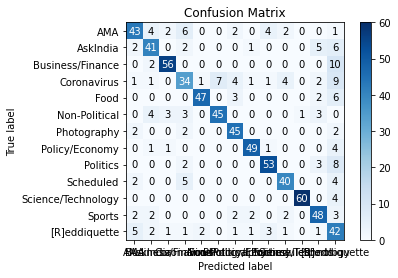

In [38]:
run_the_sv_models('sv2', X_train_text_df, X_test_text_df, y_train, y_test)

##### TFIDF Vectorizer

Fitting 5 folds for each of 3 candidates, totalling 15 fits
Train score = 0.6576923076923077
Test score = 0.5628205128205128
--------


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    0.1s finished
/opt/conda/lib/python3.7/site-packages/sklearn/naive_bayes.py:507: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


AxesSubplot(0.125,0.125;0.62x0.755)
Best params = {'alpha': 0, 'fit_prior': True}
----F1 Score, Recall, Precision----
                    precision    recall  f1-score   support

               AMA       0.53      0.42      0.47        64
          AskIndia       0.42      0.61      0.50        57
  Business/Finance       0.59      0.51      0.55        68
       Coronavirus       0.60      0.37      0.46        65
              Food       0.75      0.76      0.75        58
     Non-Political       0.56      0.41      0.47        59
       Photography       0.38      0.57      0.46        51
    Policy/Economy       0.67      0.89      0.76        56
          Politics       0.65      0.56      0.60        66
         Scheduled       0.43      0.37      0.40        51
Science/Technology       0.76      0.83      0.79        64
            Sports       0.53      0.51      0.52        61
     [R]eddiquette       0.48      0.52      0.50        60

          accuracy                      

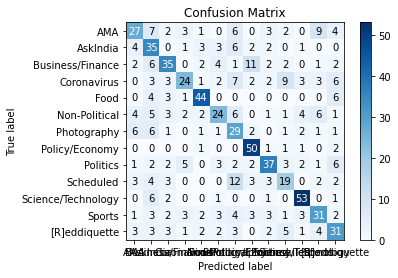

In [39]:
run_the_mn_models('mnb1', X_train_tfidf_text_df, X_test_tfidf_text_df, y_train, y_test)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
Train score = 0.6620879120879121
Test score = 0.5717948717948718
--------


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    0.1s finished
/opt/conda/lib/python3.7/site-packages/sklearn/naive_bayes.py:507: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


AxesSubplot(0.125,0.125;0.62x0.755)
Best params = {'alpha': 0, 'fit_prior': False}
----F1 Score, Recall, Precision----
                    precision    recall  f1-score   support

               AMA       0.44      0.44      0.44        64
          AskIndia       0.42      0.61      0.50        57
  Business/Finance       0.61      0.57      0.59        68
       Coronavirus       0.64      0.43      0.51        65
              Food       0.75      0.76      0.75        58
     Non-Political       0.66      0.39      0.49        59
       Photography       0.42      0.51      0.46        51
    Policy/Economy       0.67      0.89      0.76        56
          Politics       0.63      0.61      0.62        66
         Scheduled       0.53      0.35      0.42        51
Science/Technology       0.74      0.83      0.78        64
            Sports       0.52      0.52      0.52        61
     [R]eddiquette       0.48      0.50      0.49        60

          accuracy                     

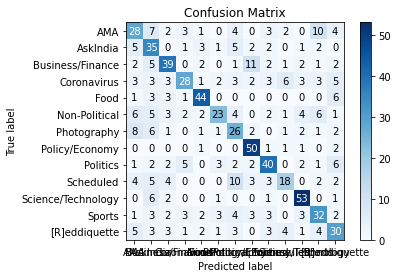

In [40]:
run_the_mn_models('mnb2', X_train_tfidf_text_df, X_test_tfidf_text_df, y_train, y_test)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    2.0s finished


Train score = 0.8021978021978022
Test score = 0.6141025641025641
--------
AxesSubplot(0.125,0.125;0.62x0.755)
Best params = {'C': 2.5, 'class_weight': 'balanced', 'penalty': 'l1', 'random_state': 42, 'solver': 'liblinear', 'warm_start': True}
----F1 Score, Recall, Precision----
                    precision    recall  f1-score   support

               AMA       0.60      0.52      0.55        64
          AskIndia       0.47      0.49      0.48        57
  Business/Finance       0.75      0.65      0.69        68
       Coronavirus       0.51      0.52      0.52        65
              Food       0.83      0.76      0.79        58
     Non-Political       0.56      0.49      0.52        59
       Photography       0.42      0.69      0.52        51
    Policy/Economy       0.83      0.86      0.84        56
          Politics       0.66      0.59      0.62        66
         Scheduled       0.41      0.41      0.41        51
Science/Technology       0.92      0.86      0.89        64


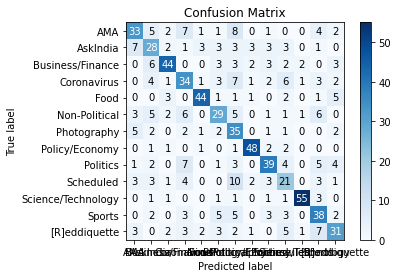

In [41]:
run_the_lr_models('lr1', X_train_tfidf_text_df, X_test_tfidf_text_df, y_train, y_test)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    4.9s finished


Train score = 0.7807692307692308
Test score = 0.6166666666666667
--------
AxesSubplot(0.125,0.125;0.62x0.755)
Best params = {'C': 2.5, 'class_weight': 'balanced', 'penalty': 'l2', 'random_state': 42, 'solver': 'liblinear', 'warm_start': True}
----F1 Score, Recall, Precision----
                    precision    recall  f1-score   support

               AMA       0.58      0.48      0.53        64
          AskIndia       0.50      0.53      0.51        57
  Business/Finance       0.74      0.71      0.72        68
       Coronavirus       0.59      0.58      0.59        65
              Food       0.81      0.74      0.77        58
     Non-Political       0.60      0.53      0.56        59
       Photography       0.38      0.67      0.49        51
    Policy/Economy       0.78      0.88      0.82        56
          Politics       0.67      0.55      0.60        66
         Scheduled       0.53      0.41      0.46        51
Science/Technology       0.93      0.89      0.91        64


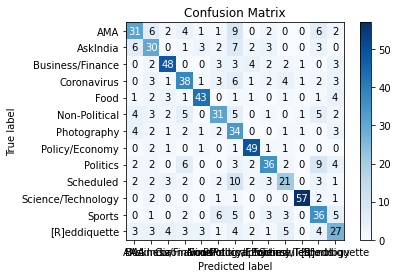

In [42]:
run_the_lr_models('lr2', X_train_tfidf_text_df, X_test_tfidf_text_df, y_train, y_test)

Fitting 5 folds for each of 576 candidates, totalling 2880 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   21.5s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   35.6s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 920 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 1370 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 1920 tasks      | elapsed:  5.2min
[Parallel(n_jobs=-1)]: Done 2674 tasks      | elapsed:  7.7min
[Parallel(n_jobs=-1)]: Done 2880 out of 2880 | elapsed:  8.4min finished


Train score = 0.9895604395604396
Test score = 0.7974358974358975
--------
AxesSubplot(0.125,0.125;0.62x0.755)
Best params = {'bootstrap': False, 'criterion': 'gini', 'max_depth': None, 'max_features': 0.25, 'min_samples_split': 15, 'n_estimators': 24, 'random_state': 42, 'warm_start': True}
----F1 Score, Recall, Precision----
                    precision    recall  f1-score   support

               AMA       0.81      0.78      0.79        64
          AskIndia       0.68      0.79      0.73        57
  Business/Finance       0.76      0.94      0.84        68
       Coronavirus       0.65      0.60      0.62        65
              Food       0.80      0.88      0.84        58
     Non-Political       0.90      0.80      0.85        59
       Photography       0.80      0.84      0.82        51
    Policy/Economy       0.91      0.91      0.91        56
          Politics       0.86      0.83      0.85        66
         Scheduled       0.83      0.86      0.85        51
Science/Tec

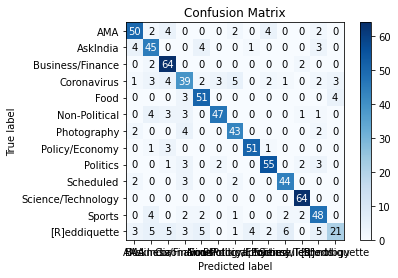

In [43]:
run_the_rf_models('rf1', X_train_tfidf_text_df, X_test_tfidf_text_df, y_train, y_test)

Fitting 5 folds for each of 576 candidates, totalling 2880 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  6.3min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:  9.4min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed: 15.2min
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed: 21.1min
[Parallel(n_jobs=-1)]: Done 2880 out of 2880 | elapsed: 27.0min finished


Train score = 0.9895604395604396
Test score = 0.7871794871794872
--------
AxesSubplot(0.125,0.125;0.62x0.755)
Best params = {'bootstrap': False, 'criterion': 'entropy', 'max_depth': None, 'max_features': 0.25, 'min_samples_split': 5, 'n_estimators': 24, 'random_state': 42, 'warm_start': True}
----F1 Score, Recall, Precision----
                    precision    recall  f1-score   support

               AMA       0.81      0.80      0.80        64
          AskIndia       0.69      0.79      0.74        57
  Business/Finance       0.74      0.88      0.81        68
       Coronavirus       0.59      0.55      0.57        65
              Food       0.82      0.84      0.83        58
     Non-Political       0.82      0.76      0.79        59
       Photography       0.73      0.88      0.80        51
    Policy/Economy       0.88      0.91      0.89        56
          Politics       0.93      0.79      0.85        66
         Scheduled       0.74      0.82      0.78        51
Science/T

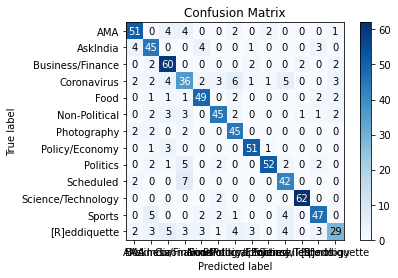

In [44]:
run_the_rf_models('rf2', X_train_tfidf_text_df, X_test_tfidf_text_df, y_train, y_test)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:   16.1s finished


Train score = 0.8835164835164835
Test score = 0.6692307692307692
--------
AxesSubplot(0.125,0.125;0.62x0.755)
Best params = {'C': 1000, 'gamma': 0.001, 'kernel': 'rbf'}
----F1 Score, Recall, Precision----
                    precision    recall  f1-score   support

               AMA       0.61      0.52      0.56        64
          AskIndia       0.57      0.63      0.60        57
  Business/Finance       0.76      0.82      0.79        68
       Coronavirus       0.62      0.62      0.62        65
              Food       0.80      0.74      0.77        58
     Non-Political       0.64      0.63      0.63        59
       Photography       0.47      0.78      0.58        51
    Policy/Economy       0.80      0.86      0.83        56
          Politics       0.71      0.59      0.64        66
         Scheduled       0.61      0.49      0.54        51
Science/Technology       0.97      0.89      0.93        64
            Sports       0.62      0.67      0.65        61
     [R]eddiqu

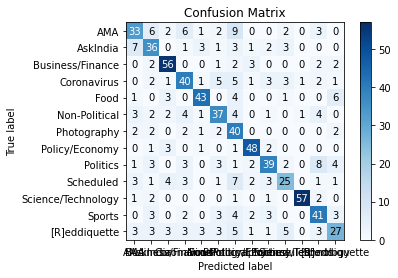

In [45]:
run_the_sv_models('sv1', X_train_tfidf_text_df, X_test_tfidf_text_df, y_train, y_test)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   15.7s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:   28.4s finished


Train score = 0.989010989010989
Test score = 0.8051282051282052
--------
AxesSubplot(0.125,0.125;0.62x0.755)
Best params = {'C': 10, 'gamma': 1, 'kernel': 'rbf'}
----F1 Score, Recall, Precision----
                    precision    recall  f1-score   support

               AMA       0.82      0.78      0.80        64
          AskIndia       0.75      0.79      0.77        57
  Business/Finance       0.80      0.82      0.81        68
       Coronavirus       0.66      0.71      0.68        65
              Food       0.90      0.81      0.85        58
     Non-Political       0.92      0.75      0.82        59
       Photography       0.71      0.88      0.79        51
    Policy/Economy       0.89      0.91      0.90        56
          Politics       0.91      0.80      0.85        66
         Scheduled       0.78      0.78      0.78        51
Science/Technology       0.97      0.97      0.97        64
            Sports       0.71      0.87      0.78        61
     [R]eddiquette   

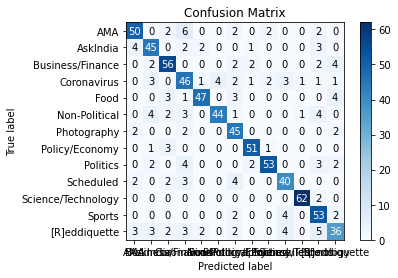

In [46]:
run_the_sv_models('sv2', X_train_tfidf_text_df, X_test_tfidf_text_df, y_train, y_test)

##### And hence, TFIDF Vectors and SVC with {'C': 10, 'gamma': 1, 'kernel': 'rbf'} are selected.

## Conclusion
Given that all the models overfit (possibly due to the size of the dataset, the mutual codependence and correlations between classes, and _Hinglish_ present within the textual data) I'm choosing the SVC with 'C' = 10, 'gamma' =  1 and 'rbf' kernel is selected as it performs the best out of all the models tested

## The Learning Curve

<module 'matplotlib.pyplot' from '/opt/conda/lib/python3.7/site-packages/matplotlib/pyplot.py'>

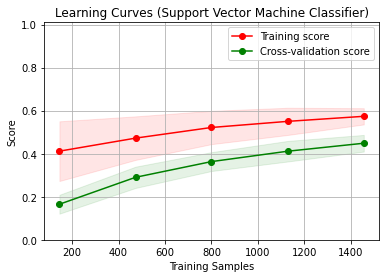

In [75]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training Samples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt



title = "Learning Curves (Support Vector Machine Classifier)"
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)

estimator = SVC()
plot_learning_curve(estimator, title, X_train_text_df.values, y_train, ylim=(0, 1.01), cv=cv, n_jobs=4)

Therefore I can conclude that one of the reasons my model fails to perform is because of the size of the dataset sampled.
## Observations & Conclusions
According to the performance metrics seen above (Precision, Recall and F1 Score) my model would probably perform worse when it comes to {R}eddiquette and Scheduled flaired posts than the other classes.
### Possible scope of improvements
>1. Increasing the size of data sampled.
>2. Time based splitting as topics evolve with time.
>3. Building classe vocabulary that's mutually exclusiv and strong enough to out perform this result.
>4. Cleaning off or Parsing the _hinglish_ in the data sampled.
>5. Better vectorizers such as GloVe, FastText, StarSpace, etc.
>6. Deep Learning Models (such as RNN LSTMs, BERT, etc..) to deal with the complex space boundaries among classes as observed in tSNE analysis.